In [1]:
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:98% !important; }</style>"))

# Additional code so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
import cv2

from ui_utils import RegDataFilterUI
import degradation_utils as hp
from ipywidgets import widgets, Layout, HBox, VBox

In [ ]:
# path for image and mask
# img_dir = "../segmentation/data/bdd100k/images/val/"
# mask_dir = "../segmentation/data/bdd100k/generated_masks_v0_1/val/"

# annotations_dir = "../regression/data/bdd100k/annotations/val/"
# output_dir = "./output/filtered_annotations/val/"

d_type = "train"
img_dir = f"/cs6945share/retro_project/bdd100k/images/{d_type}/"
mask_dir = f"/cs6945share/retro_project/bdd100k/generated_masks_v0_3/masks_v3/{d_type}/"

annotations_dir = f"/cs6945share/retro_project/regression_bdd100k/annotations/{d_type}/"
output_dir = f"./output/filtered_annotations/{d_type}/"

reg_ui = RegDataFilterUI(img_dir=img_dir, mask_dir=mask_dir, annot_dir=annotations_dir, output_dir=output_dir)

In [ ]:
reg_ui.display_UI()

In [ ]:
# 40c3d445-a5194bdd.jpg

In [15]:
# pd.read_csv("./output/filtered_annotations/val/filtered_img_names.txt")

In [16]:
# pd.read_csv("./output/filtered_annotations_2/val/filtered_img_names.txt")

# Save segements 

In [17]:
def expand_bbox(coco_bbox, image_width, image_height, padding=10):
    """
    Expands the COCO bounding box by adding padding around it.
    
    Args:
        coco_bbox (list): Original bounding box in COCO format [x_min, y_min, width, height].
        image_width (int): The width of the image.
        image_height (int): The height of the image.
        padding (int): The amount of padding to add around the bounding box.
    
    Returns:
        list: The new expanded bounding box [x_min, y_min, width, height].
    """
    # Unpack original bounding box
    x_min, y_min, width, height = coco_bbox
    
    # Expand the bounding box by the padding amount
    x_min_expanded = max(x_min - padding, 0)  # Ensure the x_min is not less than 0
    y_min_expanded = max(y_min - padding, 0)  # Ensure the y_min is not less than 0
    width_expanded = min(x_min + width + padding, image_width) - x_min_expanded  # Ensure width doesn't go beyond image
    height_expanded = min(y_min + height + padding, image_height) - y_min_expanded  # Ensure height doesn't go beyond image
    
    # Return the expanded bounding box
    return [x_min_expanded, y_min_expanded, width_expanded, height_expanded]

In [22]:
d_type = "val"
img_dir = f"/cs6945share/retro_project/bdd100k/images/{d_type}/"
mask_dir = f"/cs6945share/retro_project/bdd100k/generated_masks_v0_3/masks_v3/{d_type}/"

annotations_dir = f"/cs6945share/retro_project/classification_bdd100k/filtered_annotations_3/{d_type}/"
segments_output_dir = f"/cs6945share/retro_project/classification_bdd100k/segments_v4/{d_type}/"

filtered_label_file =  f"/cs6945share/retro_project/classification_bdd100k/filtered_annotations_3/{d_type}/filtered_img_names.txt"

dilate_kernel = 16

In [23]:
# ensure all necessary folders are available
os.makedirs(segments_output_dir, exist_ok=True)

try:
    # read list of image names filtered by the user
    with open(filtered_label_file, "r") as file:
        content = file.read()
        img_names = content.split("\n")
        img_names = list(filter(None, img_names))   # remove null strings

except FileNotFoundError:
    print(f"Error: File not found at {label_file}")
    img_names = []

In [24]:
segment_label_list = []
for img_name in tqdm(img_names):
    
    # read image and mask
    img_path = os.path.join(img_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    file_initials = ".".join(img_name.split(".")[:-1])  # remove extension 

    mask_name = f"{file_initials}.png"
    mask_path = os.path.join(mask_dir, mask_name)

    mask_img = cv2.imread(mask_path)
    mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
    # if range of image is [0, 255] normalize it
    if np.max(mask_img) > 1:
        mask_img = mask_img / 255  # normalize
    mask_img = mask_img.astype(np.uint8)

    # load annotations
    annot_name = f"{file_initials}.json"
    fp = os.path.join(annotations_dir, annot_name)
    with open(fp, 'r') as file:
        annot_data = json.load(file)

    # generate connected components
    num_labels, label_mask, bboxes = hp.generate_connected_components(mask_img, connectivity=8)
    
    # save each annotations segments 
    segment_labels = []
    for annot in annot_data["annotations"]:

        idx = annot["id"]
        target = annot.get("manual_checked_degradation_target", -1)
        if target >= 0:

            coco_bbox = annot["bounding_box"]   # get bbox (top-left-x, top-left-y, width, height)
            expanded_coco_bbox = expand_bbox(coco_bbox=coco_bbox, image_width=img.shape[1], image_height=img.shape[0], padding=10)

            xmin, ymin, xmax, ymax = hp.box_coco_to_corner(expanded_coco_bbox)

            # get segment in original image
            orig_mask = (label_mask == idx).astype(np.uint8)

            # # dilate the mask to include surrounding road region near lane marking
            # kernel = np.ones((dilate_kernel, dilate_kernel))
            # dilated_mask = cv2.dilate(orig_mask, kernel, iterations=1)
        
            # # use this dialted region to get neighboring road color info
            # segment = cv2.bitwise_and(img, img, mask=dilated_mask)
            segment = img.copy()
            segment = segment[ymin:ymax + 1, xmin:xmax + 1].copy()      # get specific segment crop

            # Write the segment to the output dir
            segment_name = f"{file_initials}_{idx}.png"
            segment_path = os.path.join(segments_output_dir, segment_name)
            segment = cv2.cvtColor(segment, cv2.COLOR_BGR2RGB)
            cv2.imwrite(segment_path, segment)

            segment_info = {
                    "name": segment_name,
                    "degradation_target": target
                }

            segment_labels.append(segment_info.copy())
    
    segment_label_list.extend(segment_labels)

# convert segments labels to csv and save
segment_df = pd.DataFrame(segment_label_list)
fn = f"degradation_segment_labels_{d_type}.csv"
fn = os.path.join(segments_output_dir, fn)
segment_df.to_csv(fn, index=False)
print(f"Segment label file saved at {fn}")

100%|██████████| 100/100 [00:10<00:00,  9.40it/s]


Segment label file saved at /cs6945share/retro_project/classification_bdd100k/segments_v4/val/degradation_segment_labels_val.csv


In [21]:
# !mv /cs6945share/retro_project/classification_bdd100k/segments_v4/train/degradation_segment_labels_train.csv /cs6945share/retro_project/classification_bdd100k/segments_v4/degradation_segment_labels_train.csv

In [25]:
# !mv /cs6945share/retro_project/classification_bdd100k/segments_v4/val/degradation_segment_labels_val.csv /cs6945share/retro_project/classification_bdd100k/segments_v4/degradation_segment_labels_val.csv

In [40]:
# load and test some segments as a check
d_type = "train"
segments_dir = f"/cs6945share/retro_project/classification_bdd100k/segments_v4/{d_type}/"
path = f"/cs6945share/retro_project/classification_bdd100k/segments_v4/degradation_segment_labels_{d_type}.csv"
df = pd.read_csv(path)
print(df.shape)
df.head(3)

(1235, 2)


,name,degradation_target
0,0000f77c-62c2a288_1.png,2
1,0000f77c-62c2a288_2.png,1
2,0000f77c-62c2a288_4.png,0


In [41]:
df["degradation_target"].value_counts(normalize=True)

0    0.501215
1    0.294737
2    0.204049
Name: degradation_target, dtype: float64

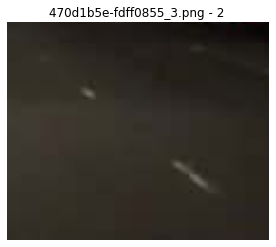

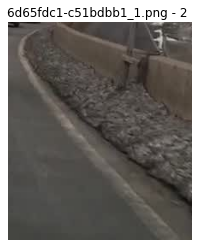

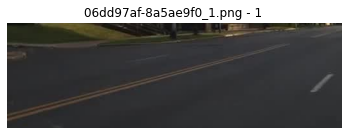

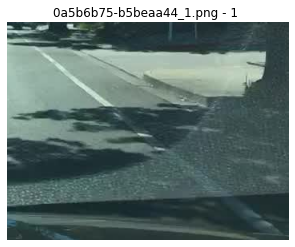

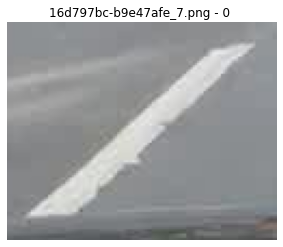

In [39]:
samples = 5
temp = df.sample(samples)

for _, row in temp.iterrows():

    img_name = row["name"]
    target = row["degradation_target"]
    
     # read image and mask
    img_path = os.path.join(segments_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{img_name} - {target} ")
    plt.show()


#### Make balanced

In [42]:
# load and test some segments as a check
d_type = "train"
segments_dir = f"/cs6945share/retro_project/classification_bdd100k/segments_v4/{d_type}/"
path = f"/cs6945share/retro_project/classification_bdd100k/segments_v4/degradation_segment_labels_{d_type}.csv"
df = pd.read_csv(path)
print(df.shape)
df.head(3)

(1235, 2)


,name,degradation_target
0,0000f77c-62c2a288_1.png,2
1,0000f77c-62c2a288_2.png,1
2,0000f77c-62c2a288_4.png,0


In [43]:
label_counts = df["degradation_target"].value_counts()
label_counts

0    619
1    364
2    252
Name: degradation_target, dtype: int64

In [44]:
# Find the size of the smallest label
min_count = label_counts.min()

# Undersample the overrepresented classes
df_balanced = df.groupby('degradation_target').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
df_balanced["degradation_target"].value_counts()

0    252
1    252
2    252
Name: degradation_target, dtype: int64

In [45]:
# path = f"/cs6945share/retro_project/classification_bdd100k/segments_v4/degradation_segment_labels_{d_type}_balanced.csv"
# df_balanced.to_csv(path, index=False)